In [3]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import keras
from keras.models import Sequential
from keras.layers import Dense, Conv2D , MaxPool2D , Flatten , Dropout , BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,confusion_matrix
from keras.callbacks import ReduceLROnPlateau
import cv2 # pip install opencv-python
import os

Description of the Pneumonia Dataset

The dataset is organized into 3 folders (train, test, val) and contains subfolders for each image category (Pneumonia/Normal). There are 5,863 X-Ray images (JPEG) and 2 categories (Pneumonia/Normal). Chest X-ray images (anterior-posterior) were selected from retrospective cohorts of pediatric patients of one to five years old from Guangzhou Women and Children’s Medical Center, Guangzhou. All chest X-ray imaging was performed as part of patients’ routine clinical care. For the analysis of chest x-ray images, all chest radiographs were initially screened for quality control by removing all low quality or unreadable scans. The diagnoses for the images were then graded by two expert physicians before being cleared for training the AI system. In order to account for any grading errors, the evaluation set was also checked by a third expert.

In [4]:
labels = ['PNEUMONIA', 'NORMAL']
img_size = 150
def get_training_data(data_dir):
    data = []  # Image data
    labels_list = []  # Label data
    
    for label in labels:
        path = os.path.join(data_dir, label)
        class_num = labels.index(label)
        for img in os.listdir(path):
            try:
                img_arr = cv2.imread(os.path.join(path, img), cv2.IMREAD_GRAYSCALE)
                resized_arr = cv2.resize(img_arr, (img_size, img_size))  # Reshaping images to preferred size
                data.append(resized_arr)  # Add the image to the data list
                labels_list.append(class_num)  # Add the corresponding label
            except Exception as e:
                print(e)

    # Convert lists to numpy arrays and return as a tuple
    return np.array(data), np.array(labels_list)


Loading the Dataset

In [16]:
train_data, train_labels  = get_training_data('chest_xray/chest_xray/train')
test_data, test_labels = get_training_data('chest_xray/test')
val_data, val_labels = get_training_data('chest_xray/val')

OpenCV(4.11.0) D:\a\opencv-python\opencv-python\opencv\modules\imgproc\src\resize.cpp:4208: error: (-215:Assertion failed) !ssize.empty() in function 'cv::resize'

OpenCV(4.11.0) D:\a\opencv-python\opencv-python\opencv\modules\imgproc\src\resize.cpp:4208: error: (-215:Assertion failed) !ssize.empty() in function 'cv::resize'



In [ ]:
train_data.shape
train_data
train_data[[1]]
train_labels

Data Visualization & Preprocessing

The data seems imbalanced . To increase the no. of training examples, we could use use data augmentation.

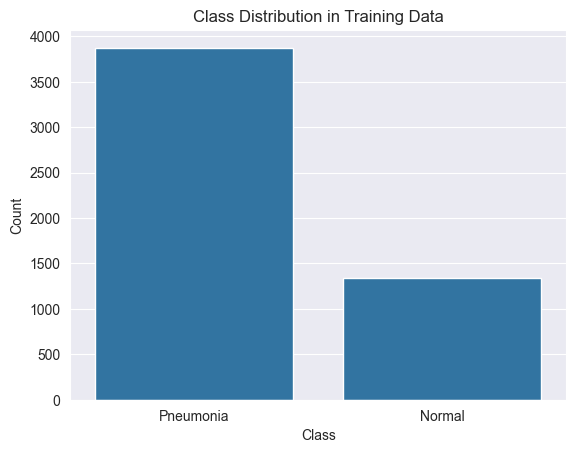

In [18]:
label_map = {0: "Pneumonia", 1: "Normal"}
l = [label_map[label] for label in train_labels]

sns.set_style('darkgrid')
sns.countplot(x=l)
plt.title("Class Distribution in Training Data")
plt.xlabel("Class")
plt.ylabel("Count")
plt.show()

array([0, 0, 0, ..., 1, 1, 1])

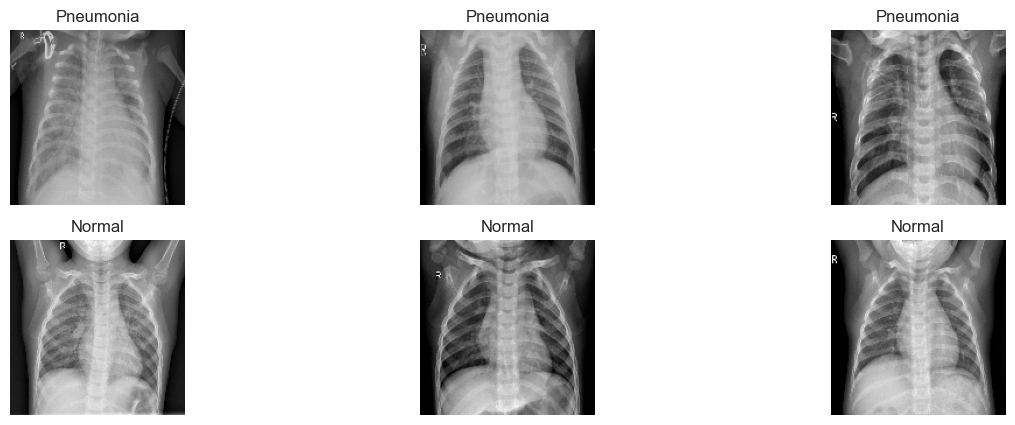

In [22]:
# Separate images based on their labels
pneumonia_images = [train_data[i] for i in range(len(train_labels)) if train_labels[i] == 0]
normal_images = [train_data[i] for i in range(len(train_labels)) if train_labels[i] == 1]

# Plot 3 Pneumonia images
plt.figure(figsize=(15, 5))
for i in range(3):
    plt.subplot(2, 3, i+1)  # 2 rows, 3 columns, i+1th subplot
    plt.imshow(pneumonia_images[i].reshape(img_size, img_size), cmap='gray')
    plt.title("Pneumonia")
    plt.axis('off')  # Hide axes

# Plot 3 Normal images
for i in range(3):
    plt.subplot(2, 3, i+4)  # 2 rows, 3 columns, i+4th subplot
    plt.imshow(normal_images[i].reshape(img_size, img_size), cmap='gray')
    plt.title("Normal")
    plt.axis('off')  # Hide axes

plt.show()

We perform a grayscale normalization to reduce the effect of illumination's differences.Moreover the CNN converges faster on [0..1] data than on [0..255].

In [25]:
# Normalize the data
x_train = np.array(train_data) / 255
x_val = np.array(val_data) / 255
x_test = np.array(test_data) / 255

In [26]:
x_test

array([[[0.07058824, 0.0627451 , 0.11764706, ..., 0.35294118,
         0.3254902 , 0.34901961],
        [0.06666667, 0.07058824, 0.11764706, ..., 0.37254902,
         0.35686275, 0.32156863],
        [0.0627451 , 0.05882353, 0.09411765, ..., 0.38039216,
         0.3372549 , 0.29803922],
        ...,
        [0.        , 0.        , 0.        , ..., 0.        ,
         0.        , 0.        ],
        [0.        , 0.        , 0.        , ..., 0.        ,
         0.        , 0.        ],
        [0.        , 0.        , 0.        , ..., 0.        ,
         0.        , 0.        ]],

       [[0.16862745, 0.15686275, 0.60784314, ..., 0.1372549 ,
         0.16078431, 0.20392157],
        [0.60784314, 0.69019608, 0.65882353, ..., 0.26666667,
         0.17254902, 0.10588235],
        [0.68235294, 0.68235294, 0.67058824, ..., 0.40392157,
         0.17647059, 0.12156863],
        ...,
        [0.23529412, 0.12941176, 0.0745098 , ..., 0.05098039,
         0.03921569, 0.11764706],
        [0.2

Summary of Why This is Necessary:
Reshaping Image Data: The deep learning model needs the image data in the format (num_samples, height, width, channels) to work with convolution layers effectively. Grayscale images need to have a channel dimension (which is 1), so they are reshaped accordingly.

Converting Labels to NumPy Arrays: Deep learning frameworks need labels in a numerical format (as NumPy arrays or tensors), and they must be able to index and manipulate the labels efficiently during training and evaluation.

What Happens After Reshaping:
After this block of code, your data will be in the proper format:

x_train, x_val, x_test: 4D arrays of shape (num_samples, img_size, img_size, 1), suitable for feeding into a neural network.

y_train, y_val, y_test: 1D arrays containing the labels, which are also ready to be used for training or evaluation.

In [27]:
# resize data for deep learning 
x_train = x_train.reshape(-1, img_size, img_size, 1)
y_train = np.array(train_labels)

x_val = x_val.reshape(-1, img_size, img_size, 1)
y_val = np.array(val_labels)

x_test = x_test.reshape(-1, img_size, img_size, 1)
y_test = np.array(test_labels)

In [ ]:
x_train.shape # 5216 images, each 150x150 pixels, with 1 channel for grayscale

(5216, 150, 150, 1)

In [32]:
# With data augmentation to prevent overfitting and handling the imbalance in dataset
datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range = 30,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.2, # Randomly zoom image 
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip = True,  # randomly flip images
        vertical_flip=False)  # randomly flip images


datagen.fit(x_train)

This model is a Convolutional Neural Network (CNN) designed for binary classification tasks, typically used in image classification. It consists of several layers aimed at extracting features from input images:

1. **Convolutional Layers**: The model uses multiple convolutional layers with increasing numbers of filters (32, 64, 128, 256), each applying 3x3 kernels to extract spatial features. These layers help in identifying patterns such as edges, textures, and more complex shapes in the images.

2. **Max-Pooling Layers**: After each convolutional block, max-pooling is applied to reduce the spatial dimensions of the feature maps, which helps in reducing computational load and controlling overfitting. The pooling size is 2x2 with a stride of 2.

3. **Batch Normalization**: This layer is used after each convolutional block to normalize the activations, which helps speed up training and stabilizes the learning process.

4. **Dropout Layers**: Dropout is used in several layers (0.1 or 0.2) to prevent overfitting. It randomly deactivates a fraction of neurons during training, forcing the model to generalize better.

5. **Flattening**: After feature extraction, the 2D feature maps are flattened into a 1D vector to be fed into fully connected (dense) layers.

6. **Dense Layers**: The model has one fully connected layer with 128 units and a ReLU activation function, followed by another dropout layer to improve generalization. The output layer is a single neuron with a sigmoid activation function, providing a probability value between 0 and 1 for binary classification.

7. **Model Compilation**: The model uses the RMSprop optimizer and binary crossentropy loss function, which are appropriate for binary classification problems. The metric used for evaluation is accuracy.

Overall, this CNN model is structured to extract hierarchical features from input images and classify them into two categories with high accuracy, using techniques like batch normalization, dropout, and max-pooling to improve training efficiency and prevent overfitting.

In [29]:
model = Sequential()
model.add(Conv2D(32 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu' , input_shape = (150,150,1)))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model.add(Conv2D(64 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model.add(Dropout(0.1))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model.add(Conv2D(64 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model.add(Conv2D(128 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model.add(Dropout(0.2))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model.add(Conv2D(256 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model.add(Dropout(0.2))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model.add(Flatten())
model.add(Dense(units = 128 , activation = 'relu'))
model.add(Dropout(0.2))
model.add(Dense(units = 1 , activation = 'sigmoid'))
model.compile(optimizer = "rmsprop" , loss = 'binary_crossentropy' , metrics = ['accuracy'])
model.summary()

C:\Users\salom\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 150, 150, 32)   │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 150, 150, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 75, 75, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 75, 75, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 75, 75, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 75, 75, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 38, 38, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 38, 38, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 38, 38, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 19, 19, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 19, 19, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 19, 19, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 19, 19, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 10, 10, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 10, 10, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 10, 10, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 10, 10, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 5, 5, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 6400)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       819,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴─────────────

 Total params: 1,246,401 (4.75 MB)

 Trainable params: 1,245,313 (4.75 MB)

 Non-trainable params: 1,088 (4.25 KB)

In [30]:
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', patience = 2, verbose=1,factor=0.3, min_lr=0.000001)

In [ ]:
history = model.fit(datagen.flow(x_train,y_train, batch_size = 32) ,epochs = 12 , validation_data = datagen.flow(x_val, y_val) ,callbacks = [learning_rate_reduction])

Epoch 1/12


C:\Users\salom\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


163/163 ━━━━━━━━━━━━━━━━━━━━ 116s 697ms/step - accuracy: 0.7951 - loss: 1.2184 - val_accuracy: 0.5000 - val_loss: 56.0755 - learning_rate: 0.0010
Epoch 2/12
163/163 ━━━━━━━━━━━━━━━━━━━━ 116s 714ms/step - accuracy: 0.8797 - loss: 0.3195 - val_accuracy: 0.5000 - val_loss: 28.8746 - learning_rate: 0.0010
Epoch 3/12
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 769ms/step - accuracy: 0.9176 - loss: 0.2357
Epoch 3: ReduceLROnPlateau reducing learning rate to 0.0003000000142492354.
163/163 ━━━━━━━━━━━━━━━━━━━━ 126s 770ms/step - accuracy: 0.9177 - loss: 0.2357 - val_accuracy: 0.5000 - val_loss: 42.9824 - learning_rate: 0.0010
Epoch 4/12
163/163 ━━━━━━━━━━━━━━━━━━━━ 116s 711ms/step - accuracy: 0.9460 - loss: 0.1538 - val_accuracy: 0.5000 - val_loss: 12.5787 - learning_rate: 3.0000e-04
Epoch 5/12
163/163 ━━━━━━━━━━━━━━━━━━━━ 155s 793ms/step - accuracy: 0.9527 - loss: 0.1413 - val_accuracy: 0.6875 - val_loss: 1.3192 - learning_rate: 3.0000e-04
Epoch 6/12
163/163 ━━━━━━━━━━━━━━━━━━━━ 142s 871ms/step - accuracy

In [ ]:
print("Loss of the model is - " , model.evaluate(x_test,y_test)[0])
print("Accuracy of the model is - " , model.evaluate(x_test,y_test)[1]*100 , "%")